### 🛠️ Modelos Predictivos

#### Paso 1: Instalación de librerías

In [1]:
!pip install pandas numpy scikit-learn lightgbm geopandas geopy folium geohash2 matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopy.geocoders import Nominatim
import geohash2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#### Paso 2: Carga y preparación inicial de datos

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [4]:

# Cargar dataset
df = pd.read_csv('data/US_Accidents_FL.csv', parse_dates=['Start_Time'], low_memory=True)

# Filtrar columnas relevantes
cols = ['Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
        'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
        'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
        'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
        'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']

df = df[cols].dropna(subset=['Start_Lat', 'Start_Lng'])

# Generar identificador de hora
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['Hour'] = df['Start_Time'].dt.hour

# Eliminar filas con fechas no convertidas
df = df.dropna(subset=["Start_Time"])

#### Paso 3: Ingeniería de características espaciales

In [5]:
# Agrupar por geohash (precisión ~5km)
df['Geohash'] = df.apply(lambda row: geohash2.encode(row['Start_Lat'], row['Start_Lng'], precision=5), axis=1)

# Calcular densidad de accidentes históricos por ubicación
historical_accidents = df.groupby('Geohash').size().reset_index(name='Historical_Accidents')
df = df.merge(historical_accidents, on='Geohash', how='left')

# Características de tipo de vía
road_features = ['Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 'Railway', 
                'Roundabout', 'Station', 'Stop', 'Traffic_Signal']
df['Road_Feature_Count'] = df[road_features].sum(axis=1)

In [6]:
df.head()

,Start_Time,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Geohash,Historical_Accidents,Road_Feature_Count
0,2016-11-30 15:36:03,27.981367,-82.326561,0.01,80.6,70.0,29.94,10.0,5.8,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,15.0,dhvrn,1010,0
1,2016-11-30 16:25:35,27.981367,-82.326561,0.01,80.6,65.0,29.94,10.0,6.9,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,16.0,dhvrn,1010,0
2,2016-11-30 16:40:31,25.627699,-80.374451,0.01,80.1,71.0,29.96,10.0,9.2,NaN,Mostly Cloudy,False,False,True,False,False,False,False,False,False,True,False,True,False,Day,16.0,dhwcg,3013,3
3,2016-11-30 16:34:57,25.899435,-80.346680,0.01,80.1,69.0,29.97,10.0,11.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,16.0,dhwg7,1487,0
4,2016-11-30 16:38:41,26.272926,-80.296432,0.01,79.0,69.0,29.98,10.0,10.4,NaN,Scattered Clouds,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,16.0,dhwvk,197,0


#### Paso 4: Ingeniería de características temporales

In [7]:
# Codificación cíclica de hora
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)

# Variables temporales
df['Weekday'] = df['Start_Time'].dt.weekday
df['Month'] = df['Start_Time'].dt.month
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['Is_Night'] = df['Sunrise_Sunset'].apply(lambda x: 1 if x == 'Night' else 0)

#### Paso 5: Preparación de datos para modelado

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Selección de características finales
features = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
            'Wind_Speed(mph)', 'Precipitation(in)', 'Hour_sin', 'Hour_cos',
            'Weekday', 'Month', 'Is_Weekend', 'Is_Night', 'Historical_Accidents',
            'Road_Feature_Count', 'Distance(mi)']

# Codificar condiciones climáticas
weather_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
weather_encoded = weather_encoder.fit_transform(df[['Weather_Condition']])
weather_cols = [f"Weather_{cat}" for cat in weather_encoder.categories_[0]]

# Escalar características numéricas
scaler = StandardScaler()
num_features = scaler.fit_transform(df[features])

# Combinar todas las características
X = np.hstack([num_features, weather_encoded])
y = np.ones(len(df))  # Todos son eventos positivos (accidentes)

# Crear datos negativos (muestreo espacial-temporal)
np.random.seed(42)
negative_samples = df.sample(n=len(df)//2, replace=True)[features + ['Weather_Condition']]
negative_samples[features] = scaler.transform(negative_samples[features])
negative_weather = weather_encoder.transform(negative_samples[['Weather_Condition']])
X_neg = np.hstack([negative_samples[features], negative_weather])
X_full = np.vstack([X, X_neg])
y_full = np.concatenate([y, np.zeros(len(X_neg))])

# Dividir datos (temporalmente)
''' 
df['Year'] = df['Start_Time'].dt.year
train_idx = df[df['Year'] < 2022].index
test_idx = df[df['Year'] >= 2022].index
X_train, X_test = X_full[train_idx], X_full[test_idx]
y_train, y_test = y_full[train_idx], y_full[test_idx]
'''
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42, stratify=y_full)



#### Paso 6: Entrenamiento del modelo LGBMClassifier (LightGBM)

In [9]:
import lightgbm as lgb
from lightgbm import early_stopping

from sklearn.metrics import roc_auc_score, f1_score

# Configuración del modelo
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42,
    'class_weight': 'balanced'
}

# Entrenamiento
model = lgb.LGBMClassifier(**params, n_estimators=1000)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='auc',
           callbacks=[early_stopping(50)]
           )



[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, class_weight='balanced',
               feature_fraction=0.9, learning_rate=0.05, n_estimators=1000,
               objective='binary', random_state=42, verbose=0)

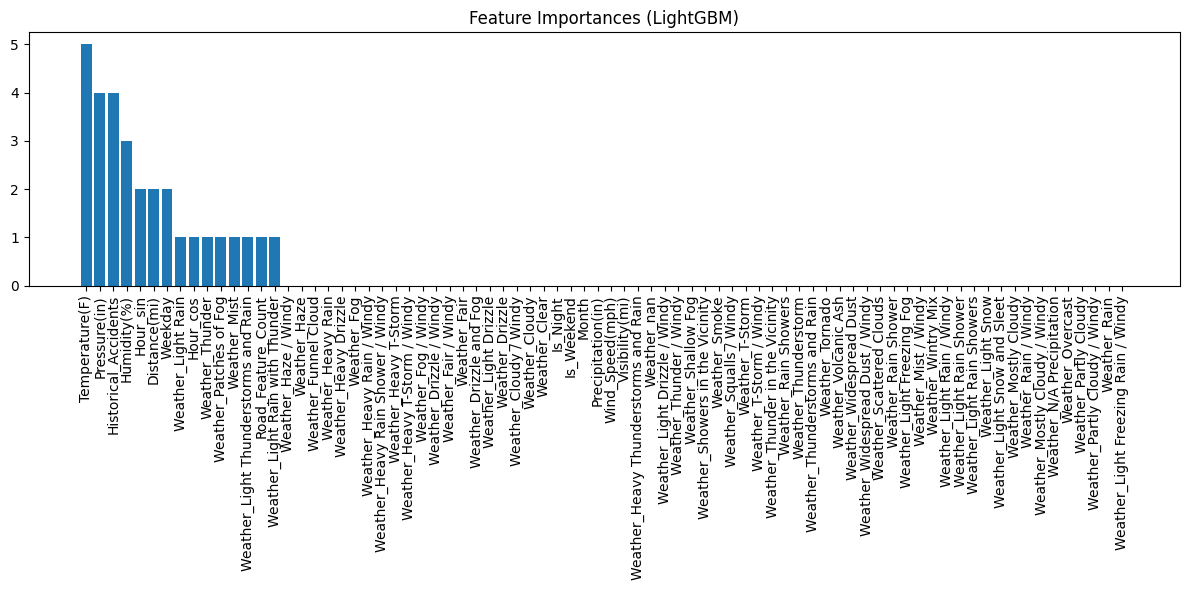

In [10]:
# Feature importance analysis
import matplotlib.pyplot as plt

feature_names = features + weather_cols
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances (LightGBM)')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [11]:

# Evaluación
y_pred = model.predict_proba(X_test)[:, 1]
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred > 0.5):.4f}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
AUC-ROC: 0.5003
F1 Score: 0.5307


c:\Users\edegr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### Generar un dataset sintetico con accidentes negativos

In [12]:
import geohash2

# Crear columna Geohash si no existe
if 'Geohash' not in df.columns:
    df['Geohash'] = df.apply(lambda row: geohash2.encode(row['Start_Lat'], row['Start_Lng'], precision=5), axis=1)

In [14]:
import pandas as pd
import numpy as np

# Supongamos que df ya está cargado con Geohash, Hour y weather_cols, y df['label']=1

# 1. Generar grid de combinaciones
unique_geohash = df['Geohash'].unique()
unique_hour = df['Hour'].unique()
synthetic_grid = pd.MultiIndex.from_product(
    [unique_geohash, unique_hour],
    names=['Geohash', 'Hour']
).to_frame(index=False)

# 2. Eliminar combinaciones reales
real_combinations = df[['Geohash', 'Hour']].drop_duplicates()
synthetic_negatives = synthetic_grid.merge(
    real_combinations,
    on=['Geohash', 'Hour'],
    how='left',
    indicator=True
)
synthetic_negatives = synthetic_negatives[synthetic_negatives['_merge'] == 'left_only']
synthetic_negatives = synthetic_negatives.drop(columns=['_merge']).reset_index(drop=True)

# 3. Crear tabla de referencia con una muestra por grupo, preservando índices de combinación
weather_cols = [
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Distance(mi)'
]
# Usamos groupby.sample y mantenemos Geohash y Hour
weather_reference = (
    df.groupby(['Geohash', 'Hour'])
      .apply(lambda g: g.sample(1, random_state=42)[weather_cols])
      .reset_index()
)
# weather_reference tendrá columnas: Geohash, Hour y weather_cols

# 4. Merge con synthetic_negatives
synthetic_negatives = synthetic_negatives.merge(
    weather_reference,
    on=['Geohash', 'Hour'],
    how='left'
)

# 5. Rellenar nulos
for col in weather_cols:
    synthetic_negatives[col] = synthetic_negatives[col].fillna(df[col].mean())

# 6. Etiquetar y unir
synthetic_negatives['label'] = 0
df_final = pd.concat([df, synthetic_negatives], ignore_index=True)

# 7. Verificar desbalance
print(df_final['label'].value_counts())


C:\Users\edegr\AppData\Local\Temp\ipykernel_37956\2871588618.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(1, random_state=42)[weather_cols])


label
0.0    61737
Name: count, dtype: int64


#### Re-entrenar con variables sinteticas

In [18]:
features = [ "Temperature(F)", "Pressure(in)", "Historical_Accidents", "Humidity(%)", "Hour_sin", "Distance(mi)", "Weekday", "Hour_cos"]
X = df_final[features]
y = df_final['label']


neg = (y == 0).sum()
pos = (y == 1).sum()
scale_pos_weight = neg / pos
print(f"Ratio negatives/positives = {scale_pos_weight:.3f}")

Ratio negatives/positives = inf


C:\Users\edegr\AppData\Local\Temp\ipykernel_37956\3651526672.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  scale_pos_weight = neg / pos


In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)



# 6. Parámetros LGBM
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 64,
    'max_depth': 10,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'subsample_freq': 5,
    'min_data_in_leaf': 20,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'verbose': -1
}

# 7. Entrenar LGBM con early stopping
model = lgb.LGBMClassifier(**params, n_estimators=5000)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[early_stopping(50)]
)


# 8. Predecir y evaluar
y_prob = model.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



ValueError: Input y contains NaN.

#### Paso 7: Entrenamiento del Modelo RandomForestClassifier 

In [ ]:
# Entrenamiento de un modelo Random Forest para el dataset df
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
#rf_model.fit(X_train, y_train)

# Evaluación
#rf_pred = rf_model.predict_proba(X_test)[:, 1]
#print(f"AUC-ROC (Random Forest): {roc_auc_score(y_test, rf_pred):.4f}")
#print(f"F1 Score (Random Forest): {f1_score(y_test, rf_pred > 0.5):.4f}")

KeyboardInterrupt: 